# GradCam: Visual Explanations via Gradient-based Localization and other visualization techniques.

At the end of this lab, you will get familiarized with

*    PCA, T-SNE and Umap visualization of layer results
*   Applying GradCam for a CNN classification
*   Visualizing gradcam results

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**
* This lab must be worked in pairs. Make sure that when you submit your lab you change the name to: **05_lab_Student1FullName_Student2FullName.ipynb**
---

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Exercise 1: Features extraction (1.5 points)

*In this section, we explored different techniques available to visualize via dimensionality reduction features developed through CNN models, first we train a model and extract its features. We use colorectal_histology from tfds leveraged before. Remember that this is multiclass problem with 8 possible categories.*


**1.1 First, lets build a model and assess its performance:**
*   Load "colorectal_histology" from TFDS
*   Only keep a 20% of the dataset as test set, as we will not be training the model.
*   Convert the labels to one-hot encoded form.
*   Normalize the images.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

print(tf.__version__)

2.14.0


In [48]:
# Load colorectal_histology from TFDS
dataset_name = 'colorectal_histology'
(train_data, test_data), info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)



AttributeError: ignored

In [6]:
train_data = train_data.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))
test_data = test_data.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))

print(test_data.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [7]:
print(f'dataset type {type(train_data)}')

# Get the total number of data points in the training and testing sets
num_train_data = tf.data.experimental.cardinality(train_data).numpy()
num_test_data = tf.data.experimental.cardinality(test_data).numpy()

# Print the total number of data points
print(f'Total number of data points in the training set: {num_train_data}')
print(f'Total number of data points in the testing set: {num_test_data}')

print(info.supervised_keys)
print(info.features.items())

dataset type <class 'tensorflow.python.data.ops.map_op._MapDataset'>
Total number of data points in the training set: 4000
Total number of data points in the testing set: 1000
('image', 'label')
dict_items([('image', Image(shape=(150, 150, 3), dtype=uint8)), ('label', ClassLabel(shape=(), dtype=int64, num_classes=8)), ('filename', Text(shape=(), dtype=string))])


In [8]:
print("Labels:", info.features['label'])

# Cast labels to integer data type
train_data = train_data.map(lambda x, y: (x, tf.cast(y, tf.int32)))
test_data = test_data.map(lambda x, y: (x, tf.cast(y, tf.int32)))

# Normalize images (x) and convert labels (y) to one-hot encoded form
num_classes = info.features['label'].num_classes
train_data = train_data.map(lambda x, y: (tf.image.per_image_standardization(x), tf.one_hot(y, num_classes)))
test_data = test_data.map(lambda x, y: (tf.image.per_image_standardization(x), tf.one_hot(y, num_classes)))


Labels: ClassLabel(shape=(), dtype=int64, num_classes=8)


In [9]:
labels_test = test_data.map(lambda x, y: y)
labels_array = np.array(list(labels_test))

**1.2 Load a fine tune a MobileNet model pretrained on ImageNet**


*   Load the model `05_lab_gradcam_model_exercise1_50epochs.keras` provided to you. This was trained for 50 epochs on this dataset, starting from the Imagenet pretrained MobileNet.



In [10]:
import os

In [13]:
#solution
pretrained_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/P08_2_Visual_Explanation/lab_08_2_gradcam_model_50epochs.keras')

**1.3 Build a model to extract the features**

*   Obtain the name of the layers. Look for *global_max_pooling2d* layer, as this will be the one where we extract the features from.
*   Create a model that outputs the features from the chosen layer. Extract the intermediate features by using the predict function from the model with the test set. **Hint:** tensorflow.keras.models has a Model function that you can use to create the intermediate model. Explore its parameters






In [15]:
#solution

# Get the summary of the model
pretrained_model.summary()

# Obtain the name of the layers
layer_names = [layer.name for layer in pretrained_model.layers]
print(layer_names)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [16]:
global_max_pooling2d_index = layer_names.index('global_max_pooling2d')

# Create a model that outputs the features from the chosen layer
intermediate_model = tf.keras.models.Model(
    inputs=pretrained_model.inputs,
    outputs=pretrained_model.layers[global_max_pooling2d_index].output
)


In [22]:
test_data = test_data.map(lambda x, y: (tf.expand_dims(x, 0), y))

In [28]:
# list(test_data)[0][1]

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [23]:
print(type(test_data))
print(test_data)

# Extract the intermediate features by using the predict function with the test set
test_features = intermediate_model.predict(test_data)

<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<_MapDataset element_spec=(TensorSpec(shape=(1, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>
1000/1000 [==============================] - 8s 8ms/step


## Exercise 2: Feature visualization with PCA (1 point)

*Principal component analysis is a popular technique for analyzing large datasets containing a high number of dimensions by reducing dimensionality while preserving the maximum amount of information, and enabling the visualization of multidimensional data.*

*For the features extracted, apply PCA and visualize the results. Comment on what you see and the advantages of this visualization in terms of explainability.*

**2.1 Perform and visualize PCA:**

*   Flatten the feature maps in order to use them in the PCA. You can do this with the reshape function.
*   Perform PCA from sklearn.decomposition with 2 components. You can use sklearn function for this.
*   Plot the resulting 2 components, color the observations by class.



In [29]:
print(test_features.shape)

(1000, 2048)


Once features are extracted, we proceed to reduce dimensionality using using PCA. Prior, we don't know if features are scaled or not, but internally PCA already substracts the mean value, so we don't have to do it.


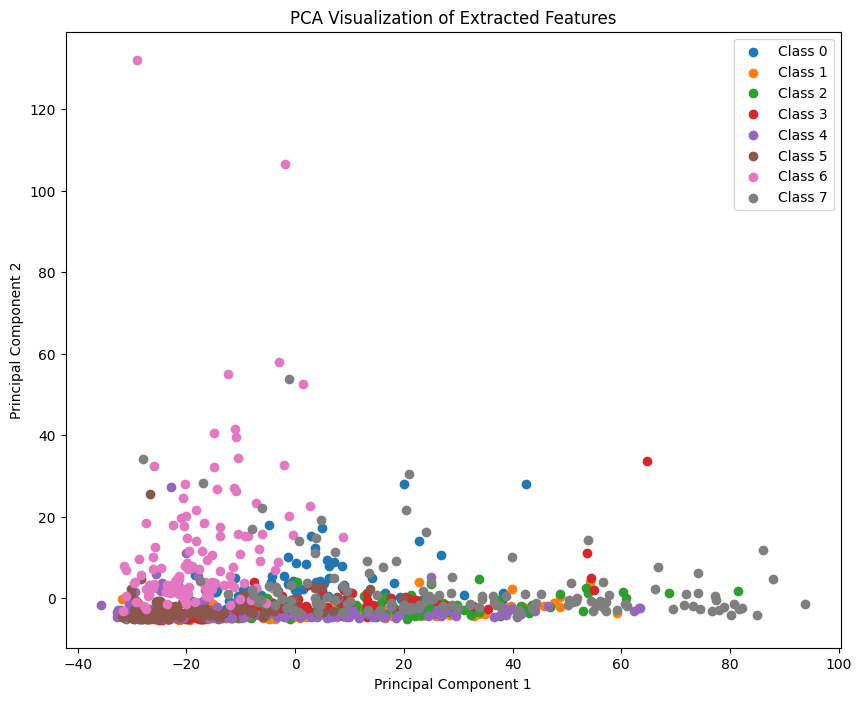

In [36]:
# solution
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# Perform PCA
num_components = 2
pca = PCA(n_components=num_components)
features_pca = pca.fit_transform(sc.fit_transform(test_features))

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    indices = np.where(np.argmax(labels_array, axis=1) == i)
    plt.scatter(features_pca[indices, 0], features_pca[indices, 1], label=f'Class {i}')

plt.title('PCA Visualization of Extracted Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

As it can be clearly observed on the plot above, there are 2 outlier data points on class 6 (On the top left of the chart). We will plot these images and compare them to the normal data points on the class to identify why are they out of the class distribution.

In [49]:
(_, test_data_copy), _ = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

outlier images idxs: [120 435]


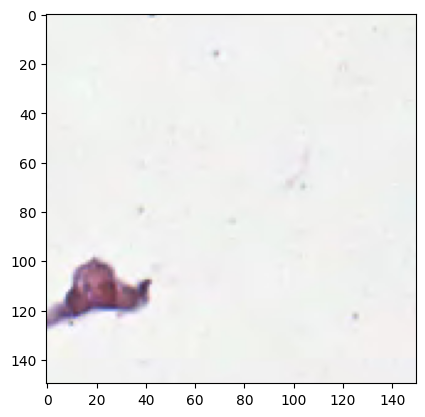

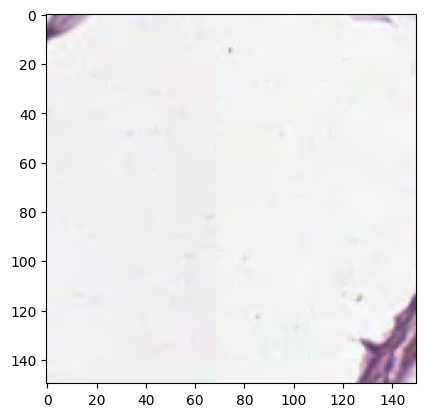

In [54]:
# features_out = features_pca[features_pca[:,1] > 80]
idx_out = np.where(features_pca[:,1] > 80)[0]
print('outlier images idxs:', idx_out)
img_out_1 = list(test_data_copy)[120][0]
img_out_2 = list(test_data_copy)[435][0]

plt.imshow(img_out_1)
plt.show()
plt.imshow(img_out_2)
plt.show()


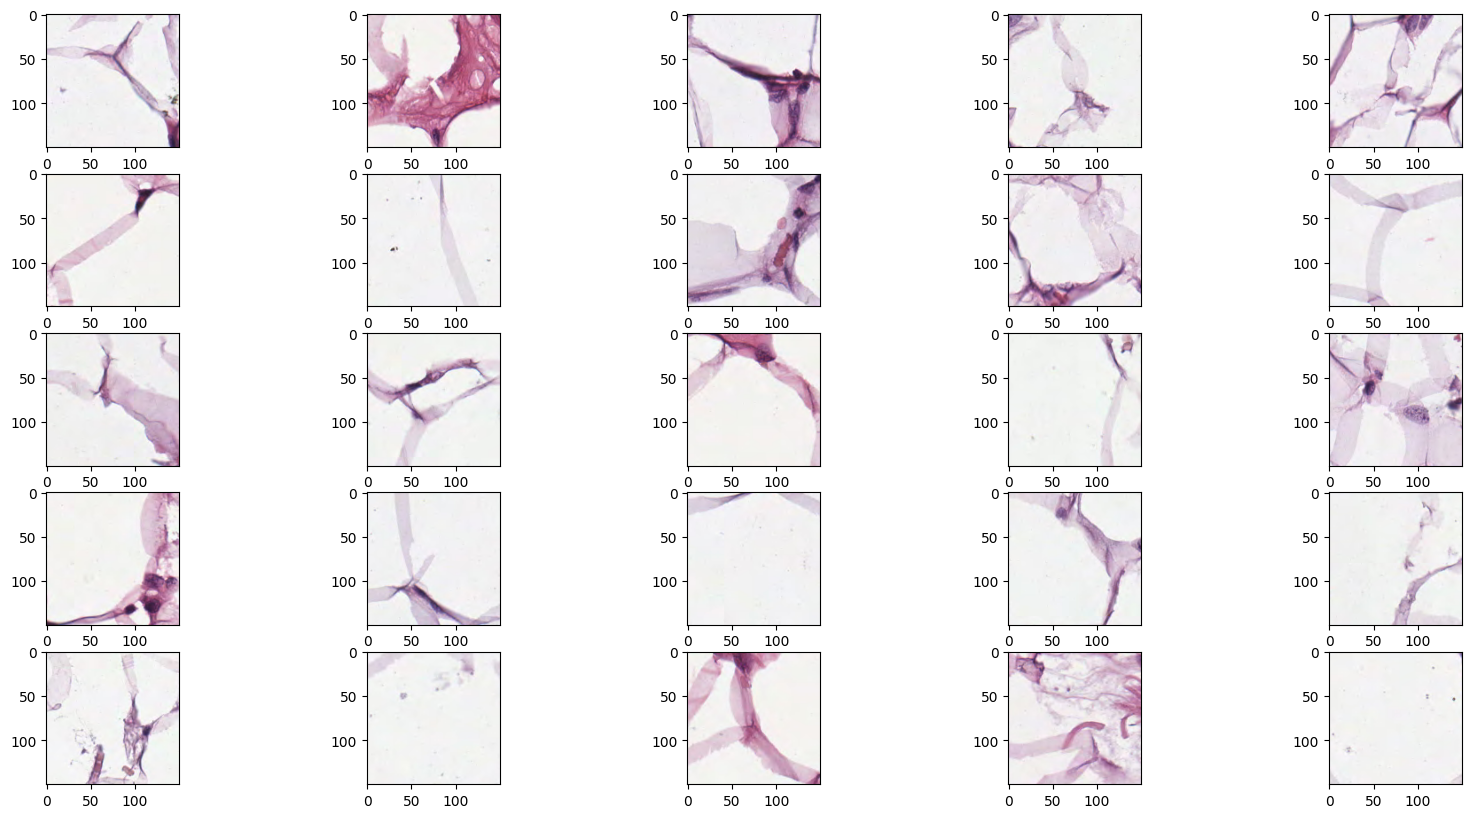

In [58]:
fig, ax = plt.subplots(5,5, figsize=(20,10))
ax = ax.ravel()
test_filter = test_data_copy.filter(lambda x, y: y==6)

for i in range(25):
  ax[i].imshow(list(test_filter)[i+10][0])

plt.show()

The 2 outlier images clearly differ of the class distribution.

## Exercise 3: Feature visualization with T-SNE (1 point)

*In order to visualize the features of a higher dimension data, t-SNE can be used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.*

*You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)*

**3.1 Use TSNE to visualize the features extracted from the neural network before. Obtain 2 components so you can easily visualize it in a 2-D plot, show your results**
**Hint:** TSNE function is available in the *sklearn.manifold* package.


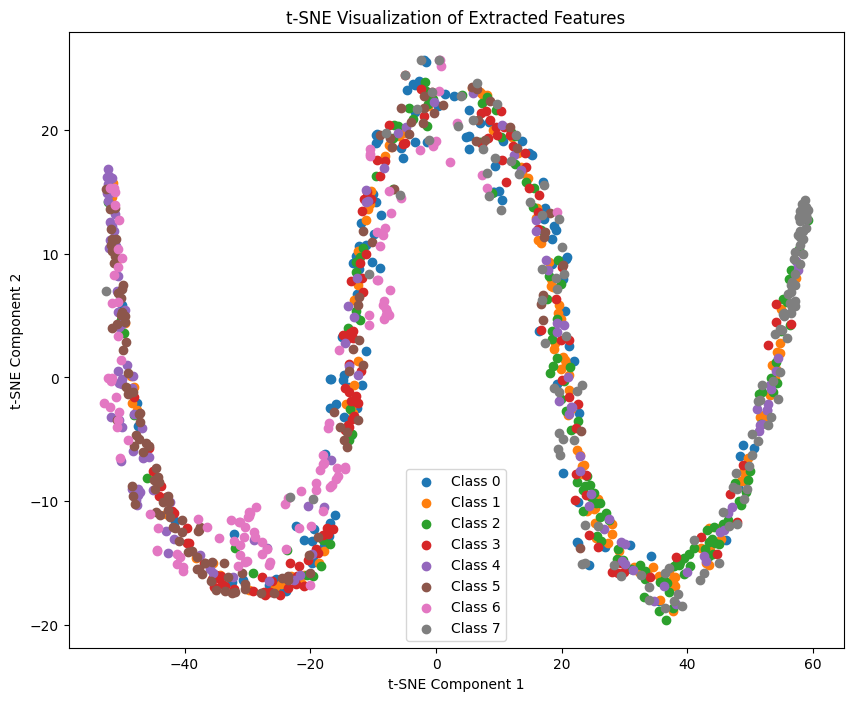

In [64]:
# solution

from sklearn.manifold import TSNE

num_components_tsne = 2
tsne = TSNE(n_components=num_components_tsne)
features_tsne = tsne.fit_transform(test_features)

# Visualize t-SNE results
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    indices = np.where(np.argmax(labels_array, axis=1) == i)
    plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], label=f'Class {i}')

plt.title('t-SNE Visualization of Extracted Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

Classes don't seem to be easily separable in T-SNE generated manifold.

# Exercise 4: Visualize features with UMAP (1 point)

*In this section, we will visualize different layers results via the dimensionality reduction technique UMAP (Uniform Manifold Approximation and Projection). This technique is a non-linear dimensionality reduction algorithm that preserves both local and global structures in the data. You can read more on its [paper](https://arxiv.org/abs/1802.03426)*



**4.1 Use UMAP to visualize results of last layer for the test set. Follow this steps:**
*   Apply the dimensionality reduction with umap from umap.umap_.
*   Set the model to use 5 neighbors and a minimum distance of 0.1 with euclidean as distance metric.
*   Once fitted and transform, visualize the UMAP embeddings as a scatterplot, with the classes as color. Use cmap = "tab10" inside the plt.scatter.



In [65]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=34fa8e3f172c218d4e4eecd37d3e03979748216ef8133ba7707e0ffe28fe26ad
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


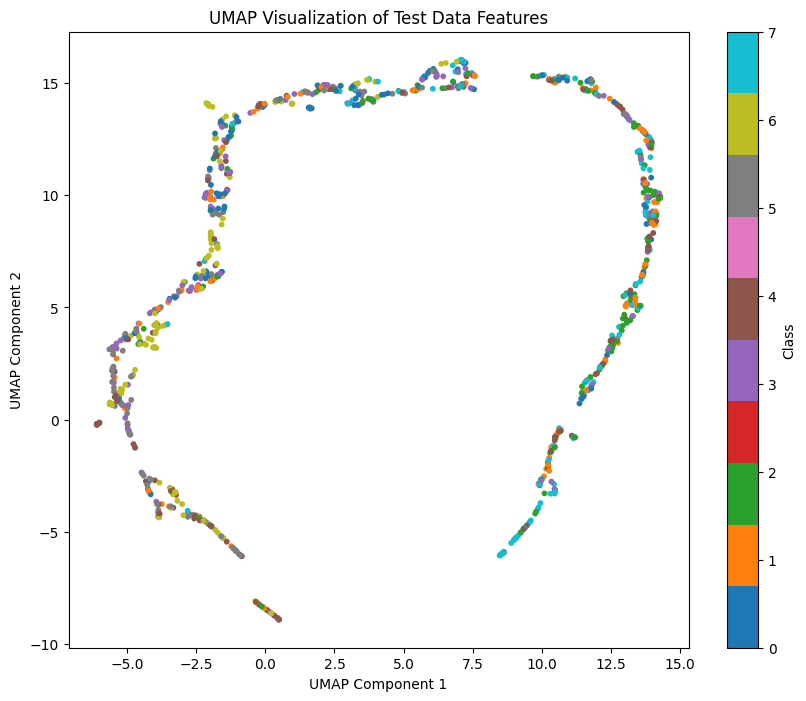

In [66]:
# solution
import umap

true_labels = np.argmax(labels_array, axis=1)

umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='euclidean')
umap_embeddings = umap_model.fit_transform(test_features)

# Visualize UMAP results
plt.figure(figsize=(10, 8))

plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=true_labels, cmap="tab10", s=10)

plt.title('UMAP Visualization of Test Data Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Class')
plt.show()

Using u-Map does not ease the separation of the classes either. Altough we can find some clusters in some parts of the plot (Class 7, Class 5).

In [70]:
import umap
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.io as pio

umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='euclidean', n_components=3)
umap_embeddings = umap_model.fit_transform(test_features)

true_labels_str = [str(x) for x in true_labels]

fig = px.scatter_3d(umap_embeddings, x=0, y=1, z=2, color=true_labels_str, opacity=1.)

fig.update_layout(
    title="3D UMAP projection of Test Data features",
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z'
    )
)

for i in range(len(fig.data)):
    fig.data[i].marker.size = 2

fig.show()


Augmenting the plot dimensionality does not help to find clusters.

# Exercise 5: Applying GradCam with a pre-trained model (1.5 points)

 Gradient-weighted Class Activation Mapping (Grad-CAM) is a technique to visualize CNN's class decisions. It shows a visual explanation to make a more transparent models. It allows to see where the layer is focusing on to pick a class. You can learn more about GradCam from a code perspective on [keras tutorial](https://keras.io/examples/vision/grad_cam/) and theoretical aspects from the [paper](https://arxiv.org/abs/1610.02391)

**5.1 Using a VGG16 already trained, you will apply gradcam to 5 ImageNet images provided in the folder "data_imagenet_sample".**

*   Load the VGG16. model pretrained in ImageNet. Make sure to set include_top = True in this case as we are going to use ImageNet images.
*   Look for the name of the last convolution layer. Save the name in order to plot its gradcam visualization



In [118]:
from keras.backend import clear_session
from keras.applications.vgg16 import VGG16

# Clear previous sessions
clear_session()

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=True)

# Print the model summary to find the name of the last convolutional layer
base_model.summary()

# Choose the last convolutional layer's name
last_conv_layer_name = 'block5_conv3'


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**5.2 Explore the 5 imagenet images:**

*   Load the images provided in `data_imagenet_sample`
*   Preprocessed them, according to what the model requires. Hint: look for the preprocess function in keras.applications.vgg16 (starter code provided)
*   Predict the class for each image. Obtain the probability and label. For this, keras.applications.imagenet_utils provides a decode predictions function. A starter code for the function to do this is provided.
*   Plot the image and print both the probability and label


You can use this base code to load the images:
```python
from keras.applications.vgg16 import VGG16, preprocess_input
# Load and preprocess the ImageNet images
def load_images(folder_path, images_names):
  image_size = (224, 224)
  images = []
  # Load images
  for image_name in images_names:
    # Load
    img = image.load_img(folder_path + image_name, target_size=image_size)
    # Preprocess image
    preprocessed_img = preprocess_input(image.img_to_array(img))
    # Add to images
    images.append(preprocessed_img)
  return images

# Prediction function
def pred_model(input_batch, model):
  # Remove last layer's softmax
  model.layers[-1].activation = None
  # Get predictions for input_batch: your code should go below
  # Get decoded predictions: your code should go below
  return decoded_predictions

```


In [114]:
# solution
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.utils import array_to_img, img_to_array

# Load and preprocess the ImageNet images
def load_images(folder_path, images_names):
  image_size = (224, 224)
  images = []
  # Load images
  for image_name in images_names:
    # Load
    img = image.load_img(folder_path + image_name, target_size=image_size)
    x = img_to_array(img)
    # Preprocess image
    preprocessed_img = preprocess_input(x)
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)
    # Add to images
    images.append(preprocessed_img)
  return images

# Prediction function
def pred_model(input_batch, model):
  # Remove last layer's softmax
  #model.layers[-1].activation = None
  # Get predictions for input_batch: your code should go below
  predictions = model.predict(input_batch)
  # Get decoded predictions: your code should go below
  decoded_predictions = decode_predictions(predictions)
  return decoded_predictions

# Load and preprocess ImageNet images
folder_path = '/content/drive/MyDrive/Colab Notebooks/P08_2_Visual_Explanation/data_imagenet_sample/'
img_names = ["ILSVRC2012_val_00008973.JPEG", "ILSVRC2012_val_00009111.JPEG", "ILSVRC2012_val_00043392.JPEG", "ILSVRC2012_val_00047139.JPEG", "ILSVRC2012_val_00047998.JPEG"]
images = load_images(folder_path, img_names)



In [97]:
# Manual test on network output

import cv2
img_ex = plt.imread(folder_path+"ILSVRC2012_val_00008973.JPEG")
img_ex = cv2.resize(img_ex, (224, 224))
img_ex_prep = preprocess_input(img_ex)
pred_prob = base_model.predict(np.expand_dims(img_ex_prep, axis=0))

np.max(tf.nn.softmax(pred_prob))

1/1 [==============================] - 0s 80ms/step


0.9977724

In [121]:
# Second test
images_test = load_images(folder_path, img_names)
decode_predictions(base_model.predict(images_test[0]))

1/1 [==============================] - 0s 32ms/step


[[('n02113186', 'Cardigan', 0.9988293),
  ('n02113023', 'Pembroke', 0.0007776728),
  ('n02106166', 'Border_collie', 0.00023129318),
  ('n02107908', 'Appenzeller', 6.0299266e-05),
  ('n02107683', 'Bernese_mountain_dog', 4.340328e-05)]]

1/1 [==============================] - 0s 25ms/step
Image 1: Cardigan (99.88% probability)
1/1 [==============================] - 0s 107ms/step
Image 2: tench (92.11% probability)
1/1 [==============================] - 0s 96ms/step
Image 3: house_finch (99.94% probability)
1/1 [==============================] - 0s 83ms/step
Image 4: washbasin (30.31% probability)
1/1 [==============================] - 0s 65ms/step
Image 5: gyromitra (99.79% probability)


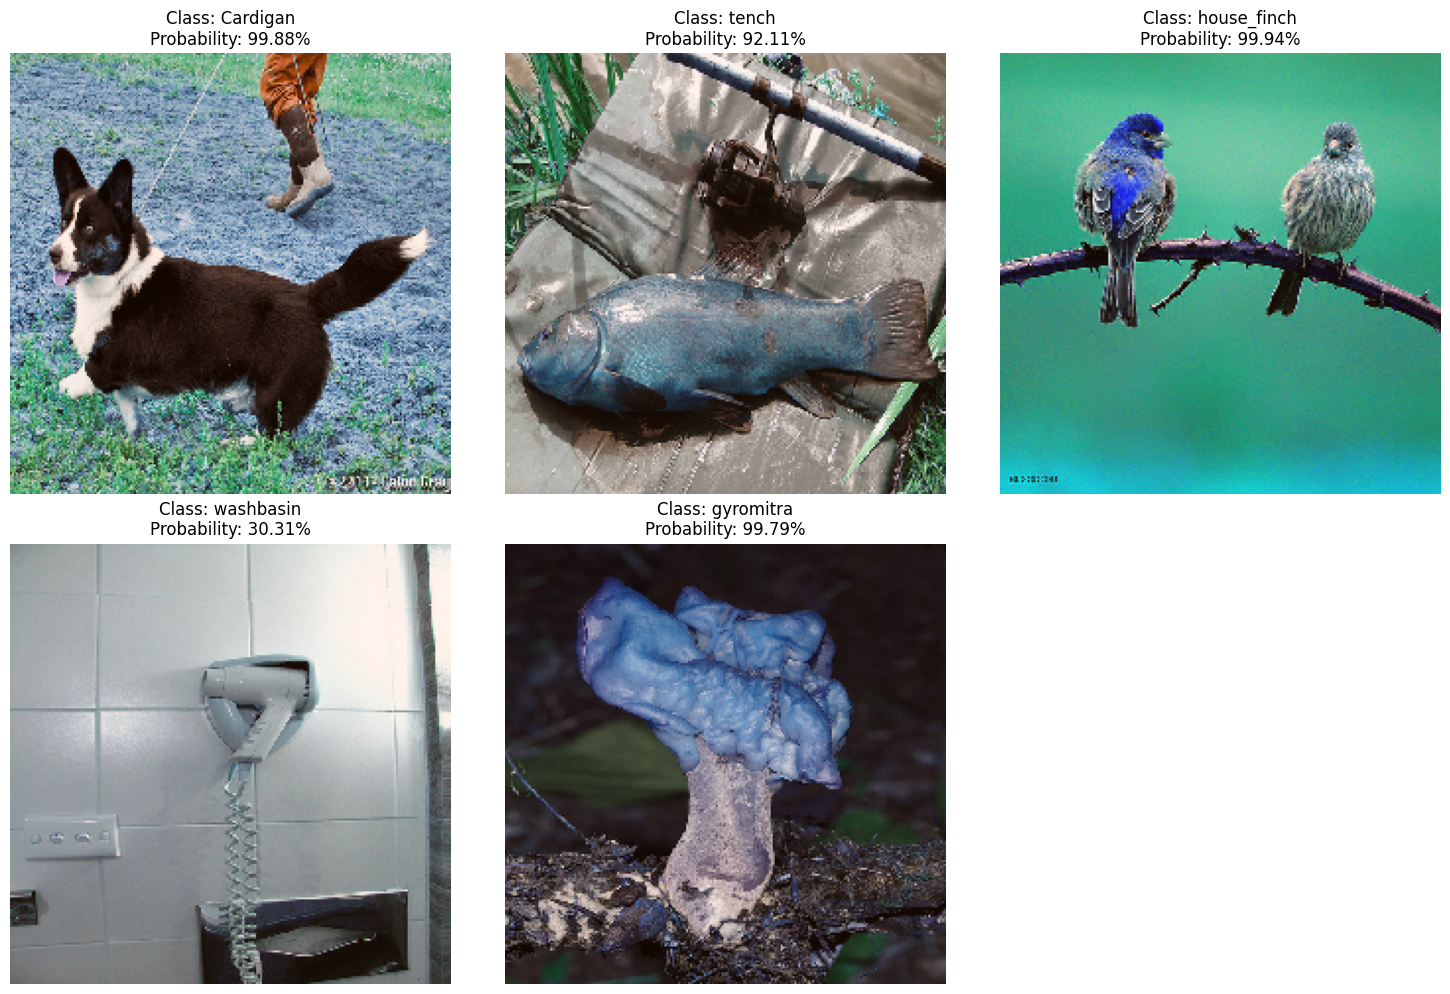

In [122]:
# Make predictions and print results
plt.figure(figsize=(15, 10))
for i, preprocessed_img in enumerate(images,1):
    predictions = pred_model(preprocessed_img, base_model)
    label, description, probability = predictions[0][0]

    # Print probability and label
    print(f"Image {i}: {description} ({probability :.2%} probability)")

    # Plot the image
    plt.subplot(2, 3, i)
    plt.imshow(image.array_to_img(preprocessed_img[0]))
    plt.title(f"Class: {description}\nProbability: {probability:.2%}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**5.3 Create the gradcam heatmap:**
*   The first step is to create a new model that maps the input image to the activations of the last convolutional layer and the output predictions.
*   Use a GradientTape to compute the gradient of the top predicted class (or a chosen class) with respect to the activations of the last convolutional layer. Use the model created as first step for this.
*   Calculate the relevance scores by taking the gradient of the output neuron (top predicted or chosen) with respect to the output feature map of the last convolutional layer.
*   Calculate a vector where each entry is the mean intensity of the gradient over a specific feature map channel. Hint: use tf.reduce_mean
*   Multiply each channel in the feature map array by its corresponding pooled gradient value to obtain the heatmap class activation.
*   For visualization purposes, normalize the heatmap values between 0 and 1. Hint: Use the functions tf.maximum and tf.math.reduce_max
* Make sure the final heatmap is a NumPy array that you can display with plt.matshow


In [149]:
# solution
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # Your code here

  # Creating a model that maps the input image to the activations of the last convolutional layer
  gradcam_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Computing the gradient of the top predicted class for the input image
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = gradcam_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the top predicted class with regard to
  # the output feature map of the last convolutional layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # Compute the mean intensity of the gradient over each feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # Multiply each channel in the feature map array by its corresponding
  # mean intensity of the gradient
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.reduce_mean(heatmap, axis=-1)

  # Normalize the heatmap between 0 and 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

  # Return the normalized heatmap as a NumPy array
  return heatmap.numpy()

**5.4 Display the heatmap for the 5 images**

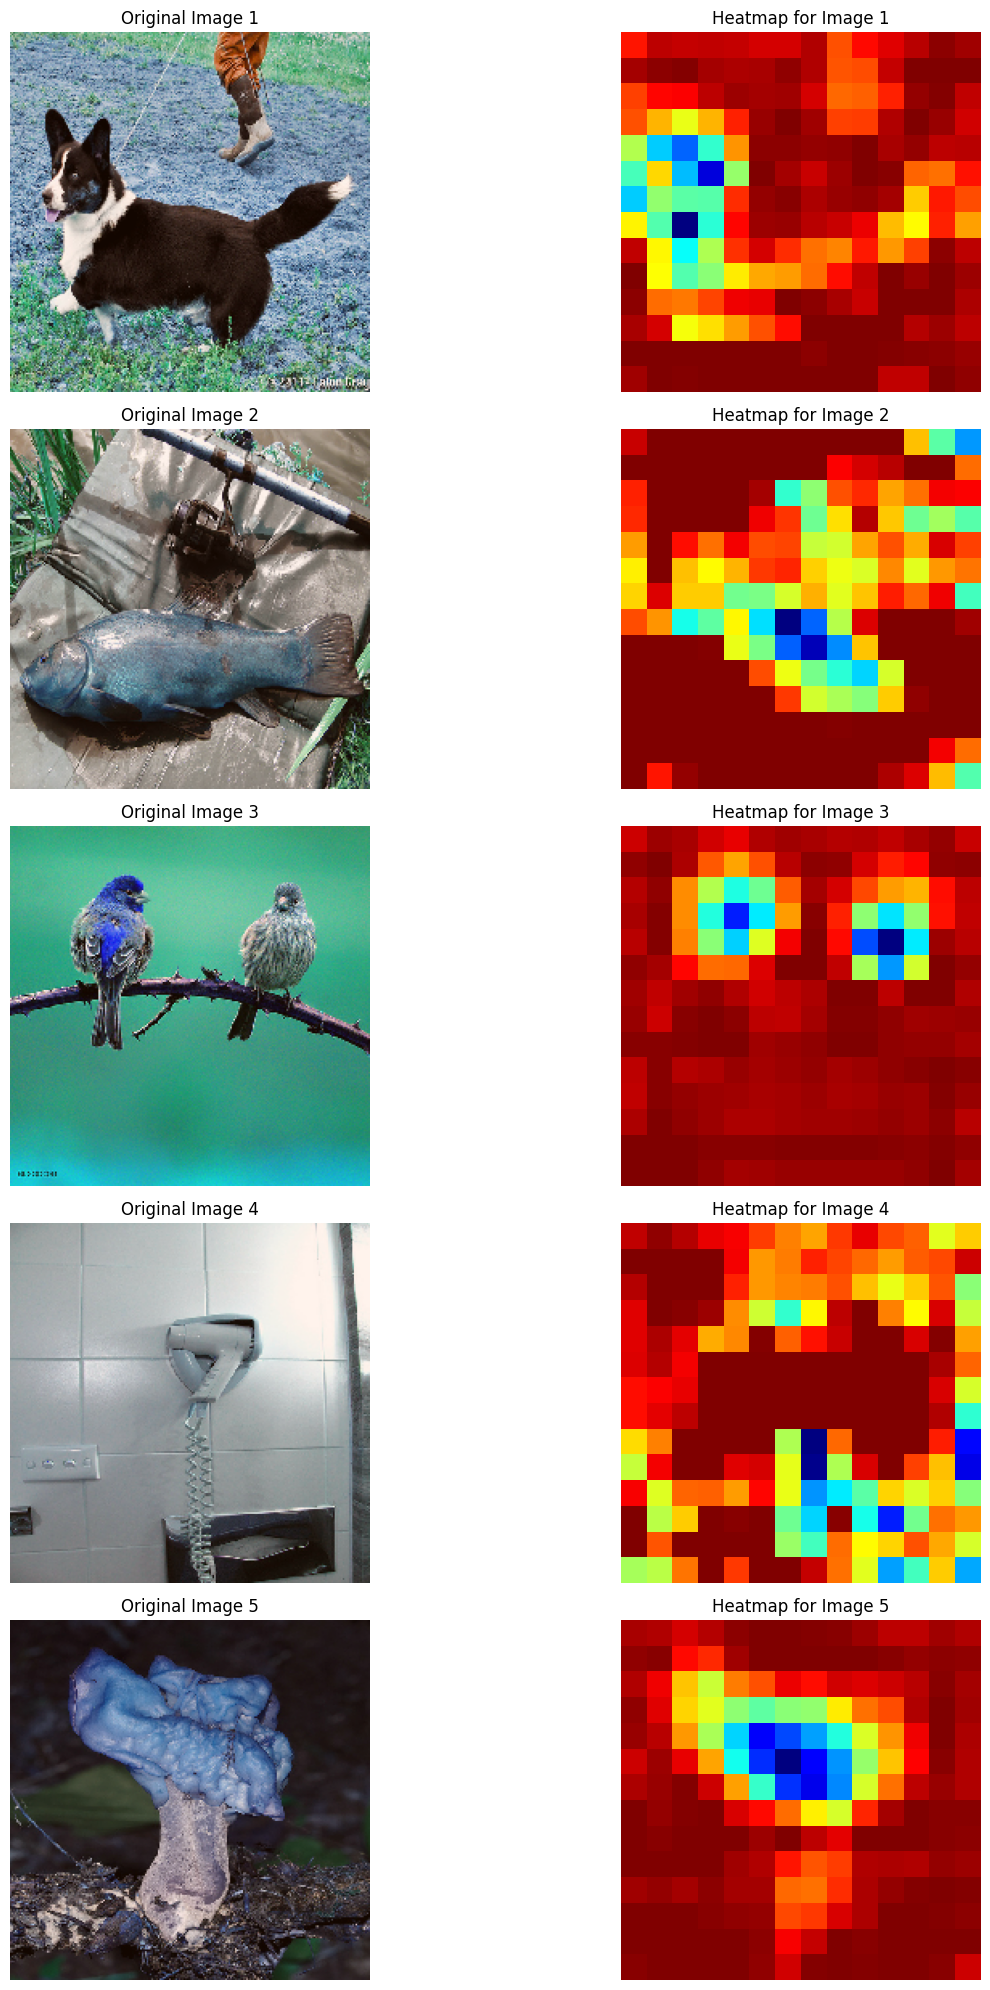

In [150]:
# solution

import cv2

# Load and preprocess the ImageNet images
images = load_images(folder_path, img_names)

# Display the heatmap for each image
plt.figure(figsize=(15, 20))

for i, preprocessed_img in enumerate(images, 1):
    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(preprocessed_img, base_model, 'block5_conv3')

    # Resize the original image to the heatmap size
    original_img = image.load_img(folder_path + img_names[i - 1], target_size=(heatmap.shape[0], heatmap.shape[1]))

    # Convert the image to a NumPy array
    original_img = img_to_array(original_img)

    # Superimpose the heatmap on the original image
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert both images to same type
    original_img = original_img.astype(np.uint8)
    heatmap = heatmap.astype(np.uint8)

    # Plot the preprocessed image
    plt.subplot(5, 2, 2 * i - 1)
    plt.imshow(array_to_img(preprocessed_img[0]))
    plt.title(f"Original Image {i}")
    plt.axis('off')

    # Plot the heatmap
    plt.subplot(5, 2, 2 * i)
    plt.imshow(heatmap)
    plt.title(f"Heatmap for Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()



**5.5 Display a superimposed visualization of the 5 images:**

Create a function that does the following:
*   Rescale the heatmap values to the range of 0-255 and use the "jet" colormap to colorize the heatmap. Use the cm.get_cmap function
*   Convert the colorized heatmap to a PIL (Python Imaging Library) image, resize it to the dimensions of the original input image, and convert it back to a NumPy array.
*   Blend the colorized heatmap with the original image using the specified alpha value. Alpha should be a value that can be determined to set the transparency of the heatmap. This looks something like this: jet_heatmap * alpha + img. Then apply keras.utils.array_to_img to the result. This will create the superimposed image to be plotted with plt.imshow



In [151]:
import matplotlib.cm as cm
from PIL import Image

# solution
def display_gradcam(img, heatmap, alpha=0.4):
  # Rescale heatmap values to the range of 0-255
  heatmap = np.uint8(255 * heatmap)

  # Apply the "jet" colormap
  jet = cm.get_cmap("jet")
  colored_heatmap = jet(heatmap)

  # Convert the colored heatmap to a PIL image
  colored_heatmap = Image.fromarray((colored_heatmap[:, :, :3] * 255).astype(np.uint8))

  # Resize the colored heatmap to the dimensions of the original input image
  original_img = array_to_img(img)
  resized_heatmap = colored_heatmap.resize(original_img.size)

  # Convert the resized heatmap back to a NumPy array
  resized_heatmap = img_to_array(resized_heatmap)
  # Blend the colored heatmap with the original image
  superimposed_img = cv2.addWeighted(resized_heatmap, alpha, img, 1 - alpha, 0)

  return superimposed_img

<ipython-input-151-8addfb634346>:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



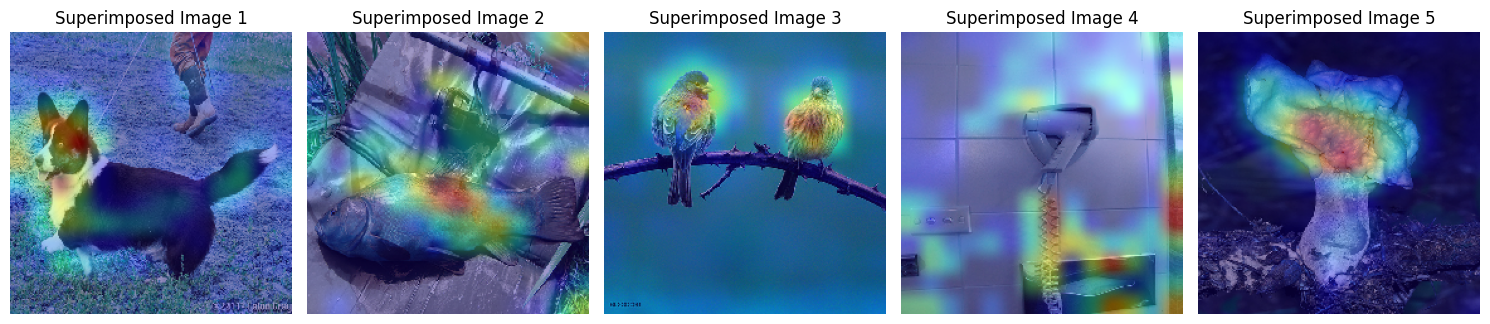

In [152]:
# Example usage:

plt.figure(figsize=(15, 5))

for i, preprocessed_img in enumerate(images, 1):
    heatmap = make_gradcam_heatmap(preprocessed_img, base_model, 'block5_conv3')
    superimposed_img = display_gradcam(preprocessed_img[0], heatmap)

    # Plot the results
    plt.subplot(1, 5, i, aspect='equal')
    plt.imshow(array_to_img(superimposed_img))
    plt.title(f"Superimposed Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Exercise 6: Apply GradCam to with Chest X-ray images dataset (3 points)

*You have used this dataset in the last lab, it contains 5,863 Chest X-Ray images classified into 2 categories (Pneumonia/Normal). The normal chest X-ray shows clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia typically exhibits a focal lobar consolidation, whereas viral pneumonia manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.*



A code to load the data and print a couple of images is provided.

In [175]:
from keras.backend import clear_session
clear_session()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape = (128, 128, 3)
batch_size = 32
n_classes = 2

folder_path_ex6 = "/content/drive/MyDrive/Colab Notebooks/P08_2_Visual_Explanation/chest_xray"

# Define the paths to your train, test, and validation directories
train_dir = folder_path_ex6 + '/train'
test_dir = folder_path_ex6 + '/test'
val_dir = folder_path_ex6 + '/val'

# Define the parameters for data augmentation and normalization
batch_size = 64
image_size = (128, 128)

# Create an instance of the ImageDataGenerator and set the preprocessing options
datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training data
train_ds = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load and preprocess the test data
test_ds = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load and preprocess the validation data
valid_ds = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Get the class indices from the flow_from_directory output
class_indices = train_ds.class_indices

# Class names
class_names = {v: k for k, v in class_indices.items()}


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


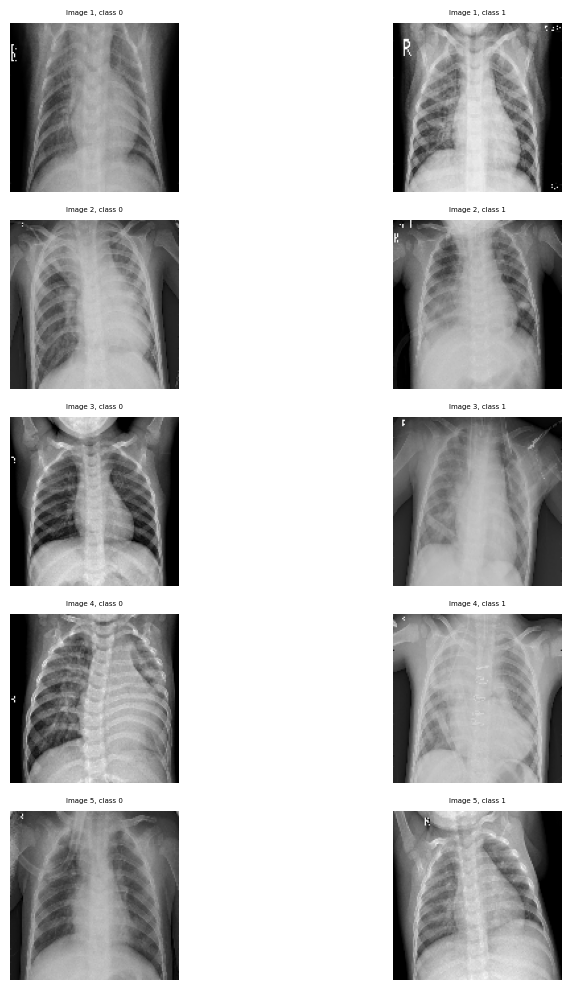

In [176]:
# Printing 5 images
n_samples = 5
idx = {}

# Getting index per each class
for number in range(n_classes):
    indices = np.where(train_ds.classes == number)[0][:n_samples]
    idx[number] = indices

# Plotting
fig, axes = plt.subplots(n_samples, n_classes, figsize=(10, 10))

for class_i, indices in idx.items():
    for id, idx in enumerate(indices):
        batch_x, batch_y = train_ds[idx // batch_size]
        img = batch_x[idx % batch_size]
        axes[id, class_i].imshow(img, cmap=plt.get_cmap('gray'))
        axes[id, class_i].set_title(f'Image {id+1}, class {class_i}', fontsize=5)
        axes[id, class_i].axis('off')

plt.tight_layout()
plt.show()


**2.2 Apply GradCam to trained models. For this consider:**
*  We are providing you with 2 models `05_lab_gradcam_model_10epochs.keras` and `05_lab_gradcam_model_25epochs.keras`. One was trained for 10 epochs and the other one for 25 epochs with a ResNet50. Load them into your environment.



In [160]:
#solution

# Load the model trained for 10 epochs
model_10epochs = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/P08_2_Visual_Explanation/lab_08_2_gradcam_model_10epochs.keras')

# Load the model trained for 25 epochs
model_25epochs = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/P08_2_Visual_Explanation/lab_08_2_gradcam_model_25epochs.keras')

**2.3 Obtain your gradcam visualization for `both` models:**
* Obtain the gradcam superimposed visualization for 5 images. Choose the last convolutional layer to do this.
* Also print the actual and predicted class
* Comment on the results - which one you think is making more sense?


<ipython-input-151-8addfb634346>:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



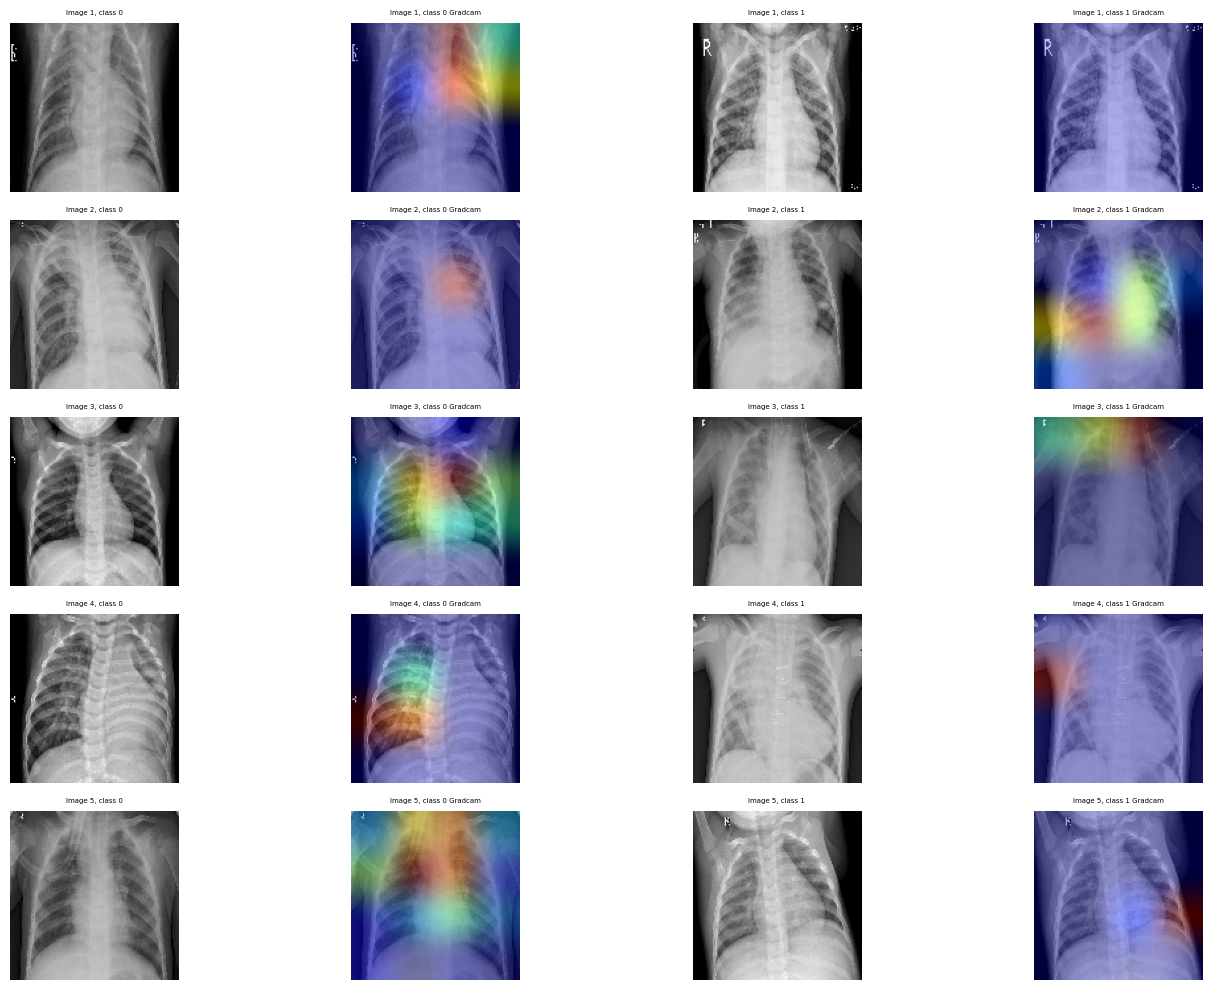

In [185]:
# Solution
# Printing 5 images with GradCAM superimposed visualization for Model_10Epochs
n_samples = 5
idx = {}

# Getting index per each class
for number in range(n_classes):
    indices = np.where(train_ds.classes == number)[0][:n_samples]
    idx[number] = indices

# Plotting
fig, axes = plt.subplots(n_samples, n_classes * 2, figsize=(15, 10))

for class_i, indices in idx.items():
    for id, idx in enumerate(indices):
        batch_x, batch_y = train_ds[idx // batch_size]
        img = batch_x[idx % batch_size]

        axes[id, class_i * 2].imshow(img, cmap=plt.get_cmap('gray'))
        axes[id, class_i * 2].set_title(f'Image {id+1}, class {class_i}', fontsize=5)
        axes[id, class_i * 2].axis('off')

        img_model = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_model, model_10epochs, 'conv5_block3_3_conv')
        superimposed_img = display_gradcam(img*255., heatmap)
        axes[id, class_i * 2 + 1].imshow(array_to_img(superimposed_img))
        axes[id, class_i * 2 + 1].set_title(f'Image {id+1}, class {class_i} Gradcam', fontsize=5)
        axes[id, class_i * 2 + 1].axis('off')

plt.tight_layout()
plt.show()


<ipython-input-151-8addfb634346>:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



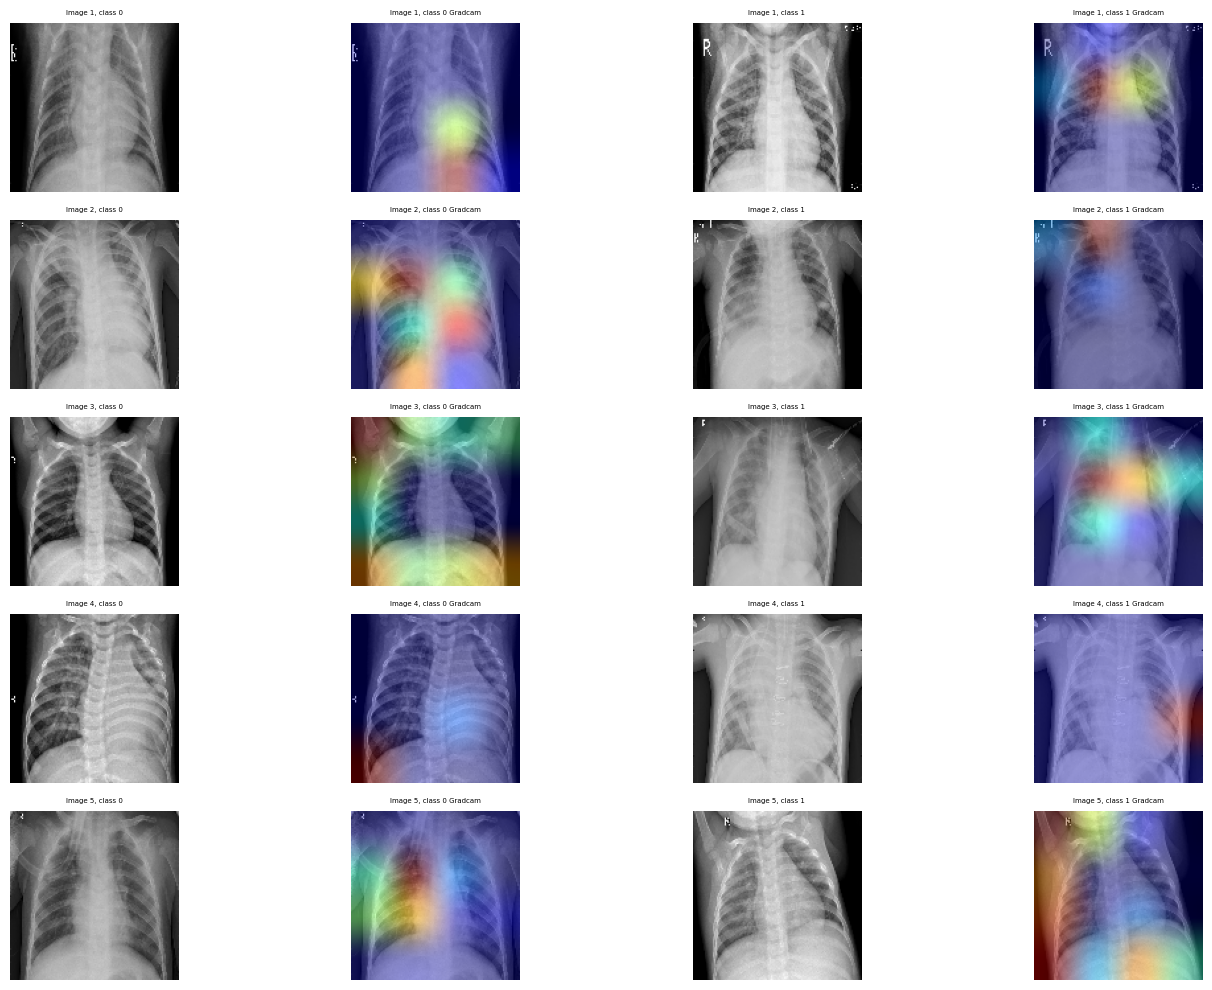

In [188]:
# Solution
# Printing 5 images with GradCAM superimposed visualization for Model_25Epochs
n_samples = 5
idx = {}

# Getting index per each class
for number in range(n_classes):
    indices = np.where(train_ds.classes == number)[0][:n_samples]
    idx[number] = indices

# Plotting
fig, axes = plt.subplots(n_samples, n_classes * 2, figsize=(15, 10))

for class_i, indices in idx.items():
    for id, idx in enumerate(indices):
        batch_x, batch_y = train_ds[idx // batch_size]
        img = batch_x[idx % batch_size]

        axes[id, class_i * 2].imshow(img, cmap=plt.get_cmap('gray'))
        axes[id, class_i * 2].set_title(f'Image {id+1}, class {class_i}', fontsize=5)
        axes[id, class_i * 2].axis('off')

        img_model = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_model, model_25epochs, 'conv5_block3_3_conv')
        superimposed_img = display_gradcam(img*255., heatmap)
        axes[id, class_i * 2 + 1].imshow(array_to_img(superimposed_img))
        axes[id, class_i * 2 + 1].set_title(f'Image {id+1}, class {class_i} Gradcam', fontsize=5)
        axes[id, class_i * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

Comment on the differences:

**SOLUTION**

The first model, trained with 10 Epochs pays attention to specific areas such as the lungs, while the second one seems to be paying more attention to the background and other body parts. So, the first model seems to be more accurate than the second one altough it's been trained for less epochs.


---

# **End of Lab 04: Interpretation with GradCAM**